# Análisis de evolución de factores de gentrificación

In [144]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
# Importar Kmeans de Sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


## <span style="color:red">Lectura de datos</span>

Para la generación del modelo, se van a trabajar con todos los datos correspondientes al año 2019 para identificar los barrios y sus diferentes niveles de gentrificación.

In [145]:
# Lectura csv edad
df_integrado = pd.read_csv('../../dataset/factores_gentrificacion_barrios.csv')
df_integrado

,COD_DISBAR,BARRIOS,ANIO,LATITUD,LONGITUD,num_hospedajes,num_terrazas,num_personas_entre_15_a_44_anios,num_personas_desempleadas,num_personas_con_educacion_superior,num_personas_extranjeras,media_personas_por_vivienda,precio_vivienda_usadas_euro_m2,valor_renta_media
0,11,PALACIO,2016,4474110.875,439417.7914,19,146.0,9752.0,1362.0,9469.0,3652.0,2.01,3257.02,31912.67
1,11,PALACIO,2018,4474110.875,439417.7914,102,158.0,9664.0,1274.0,9892.0,3854.0,2.01,4105.46,34675.85
2,11,PALACIO,2019,4474110.875,439417.7914,1088,159.0,9894.0,1235.0,10409.0,4028.0,2.03,5044.74,35509.21
3,12,EMBAJADORES,2016,4473417.211,440397.1764,42,100.0,22623.0,3349.0,15438.0,11091.0,2.07,3040.69,23917.97
4,12,EMBAJADORES,2018,4473417.211,440397.1764,153,103.0,22410.0,2907.0,16482.0,11275.0,2.04,4187.39,25999.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,213,CASCO HISTÓRICO DE BARAJAS,2016,4480530.185,450931.3676,1,1.0,3076.0,539.0,1128.0,1188.0,2.41,1973.96,33312.14
289,213,CASCO HISTÓRICO DE BARAJAS,2019,4480530.185,450931.3676,19,23.0,3161.0,386.0,1360.0,1388.0,2.43,2954.66,37427.00
290,214,TIMÓN,2018,4480810.557,448842.3002,3,17.0,5046.0,472.0,3425.0,1091.0,2.67,3226.80,40271.04
291,214,TIMÓN,2019,4480810.557,448842.3002,35,18.0,5231.0,527.0,3696.0,1230.0,2.67,3370.35,41584.00


## <span style="color:red">Generación de Indice de Gentrificación</span>

### <span style="color:blue">Normalizar Datos</span>

Previo a la creación del modelo, se van a trasnformar los datos sobre una escala de valores equivalentes. En este caso se usará el método **"Normalización por la diferencia"**.

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Dataframe solo con variables numéricas
df_analisis = df_integrado.iloc[:, 5:14]

df_Categoricas = df_integrado.iloc[:, 0:5]

factorGentrDF_numeric = df_analisis

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(factorGentrDF_numeric) 
factorGentrDF_numeric.loc[:,:] = scaled_values

dataFrameNormalizado = df_Categoricas.join(factorGentrDF_numeric)
dataFrameNormalizado.head()

,COD_DISBAR,BARRIOS,ANIO,LATITUD,LONGITUD,num_hospedajes,num_terrazas,num_personas_entre_15_a_44_anios,num_personas_desempleadas,num_personas_con_educacion_superior,num_personas_extranjeras,media_personas_por_vivienda,precio_vivienda_usadas_euro_m2,valor_renta_media
0,11,PALACIO,2016,4474110.875,439417.7914,0.008911,0.890244,0.257098,0.220388,0.383593,0.303448,0.571023,0.380771,0.308117
1,11,PALACIO,2018,4474110.875,439417.7914,0.050000,0.963415,0.254778,0.206149,0.400729,0.320233,0.571023,0.479960,0.334796
2,11,PALACIO,2019,4474110.875,439417.7914,0.538119,0.969512,0.260842,0.199838,0.421673,0.334690,0.576705,0.589769,0.342842
3,12,EMBAJADORES,2016,4473417.211,440397.1764,0.020297,0.609756,0.596425,0.541909,0.625400,0.921562,0.588068,0.355480,0.230928
4,12,EMBAJADORES,2018,4473417.211,440397.1764,0.075248,0.628049,0.590810,0.470388,0.667693,0.936851,0.579545,0.489539,0.251029


### <span style="color:blue">Cálculo índice Gentrificación</span>

In [64]:
# Aplica fórmula para el cálculo
dataFrameNormalizado['IG'] = round((dataFrameNormalizado['num_hospedajes'] + dataFrameNormalizado['num_terrazas'] + dataFrameNormalizado['num_personas_entre_15_a_44_anios'] + dataFrameNormalizado['num_personas_desempleadas'] + dataFrameNormalizado['num_personas_con_educacion_superior'] + dataFrameNormalizado['num_personas_extranjeras'] + dataFrameNormalizado['media_personas_por_vivienda'] + dataFrameNormalizado['precio_vivienda_usadas_euro_m2'] + dataFrameNormalizado['valor_renta_media'])/9,2)

# #Discretiza indice en 4 niveles
bin_labels_3 = ['Riesgo bajo de gentrificación', 'Riesgo medio de gentrificación', 'Gentrificando']
dataFrameNormalizado['ESTADOGENTRIFICACION'] = pd.qcut(dataFrameNormalizado['IG'],
                              q=3, labels=bin_labels_3)

dataFrameNormalizado.to_csv('../../dataset/barrios_indice_gentrificacion_result.csv', index=False)

dataFrameNormalizado.head()


,COD_DISBAR,BARRIOS,ANIO,LATITUD,LONGITUD,num_hospedajes,num_terrazas,num_personas_entre_15_a_44_anios,num_personas_desempleadas,num_personas_con_educacion_superior,num_personas_extranjeras,media_personas_por_vivienda,precio_vivienda_usadas_euro_m2,valor_renta_media,IG,ESTADOGENTRIFICACION
0,11,PALACIO,2016,4474110.875,439417.7914,0.008911,0.890244,0.257098,0.220388,0.383593,0.303448,0.571023,0.380771,0.308117,0.37,Gentrificando
1,11,PALACIO,2018,4474110.875,439417.7914,0.050000,0.963415,0.254778,0.206149,0.400729,0.320233,0.571023,0.479960,0.334796,0.40,Gentrificando
2,11,PALACIO,2019,4474110.875,439417.7914,0.538119,0.969512,0.260842,0.199838,0.421673,0.334690,0.576705,0.589769,0.342842,0.47,Gentrificando
3,12,EMBAJADORES,2016,4473417.211,440397.1764,0.020297,0.609756,0.596425,0.541909,0.625400,0.921562,0.588068,0.355480,0.230928,0.50,Gentrificando
4,12,EMBAJADORES,2018,4473417.211,440397.1764,0.075248,0.628049,0.590810,0.470388,0.667693,0.936851,0.579545,0.489539,0.251029,0.52,Gentrificando


In [66]:
print (dataFrameNormalizado['ESTADOGENTRIFICACION'].unique())

['Gentrificando', 'Riesgo bajo de gentrificación', 'Riesgo medio de gentrificación']
Categories (3, object): ['Riesgo bajo de gentrificación' < 'Riesgo medio de gentrificación' < 'Gentrificando']


## <span style="color:red">Análisis multivariante</span>

### <span style="color:blue">1.1 Matriz de Correlación</span>

<AxesSubplot:>

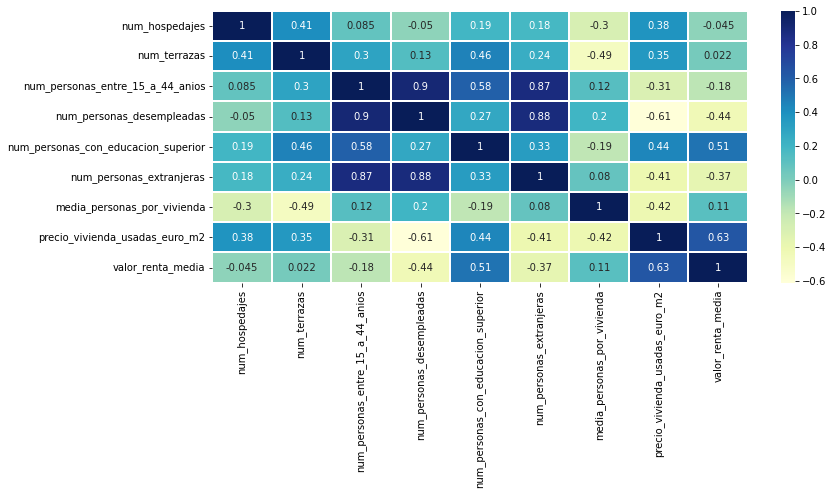

In [146]:
# Dataframe solo con variables numéricas
df_analisis = df_integrado.iloc[:, 5:14]

f, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(df_analisis.corr(method='spearman'), 
            annot=True,
            ax=ax, 
            cmap="YlGnBu", 
            linewidths=0.1)

## Conclusiones

Consideramos que dos variables tienen una importante correlación si tienen un coeficiente de correlación igual o superior a 0.85. En base a esto se puede observar que las siguientes variables están correlacionadas:

* num_personas_entre_15_a_44_anios - num_personas_desempleadas (0,9)
* num_personas_entre_15_a_44_anios - num_personas_extranjeras (0,87)
* num_personas_desempleadas - num_personas_extranjeras (0,88)

Con estos resultados, se observa correlación entre estas variables por lo tanto se va a trabajar con la variable num_personas_desempleadas ya que se demostró en el analisis previo que es muy influyente.

### <span style="color:blue">1.2 Selección de atributos</span>

In [147]:
del(df_analisis['num_personas_entre_15_a_44_anios'])
del(df_analisis['num_personas_extranjeras'])

In [148]:
df_analisis.columns

Index(['num_hospedajes', 'num_terrazas', 'num_personas_desempleadas',
       'num_personas_con_educacion_superior', 'media_personas_por_vivienda',
       'precio_vivienda_usadas_euro_m2', 'valor_renta_media'],
      dtype='object')

## <span style="color:red">Normalización de datos</span>


### <span style="color:blue">2.1 Normalización</span>

Previo a la creación del modelo, se van a trasnformar los datos sobre una escala de valores equivalentes. En este caso se usará el método **"Normalización por la diferencia"**.

In [149]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

df_Categoricas = df_integrado.iloc[:, 0:5]

factorGentrDF_numeric = df_analisis

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(factorGentrDF_numeric) 
factorGentrDF_numeric.loc[:,:] = scaled_values

dataFrameNormalizado = df_Categoricas.join(factorGentrDF_numeric)
dataFrameNormalizado.head()


,COD_DISBAR,BARRIOS,ANIO,LATITUD,LONGITUD,num_hospedajes,num_terrazas,num_personas_desempleadas,num_personas_con_educacion_superior,media_personas_por_vivienda,precio_vivienda_usadas_euro_m2,valor_renta_media
0,11,PALACIO,2016,4474110.875,439417.7914,0.008911,0.890244,0.220388,0.383593,0.571023,0.380771,0.308117
1,11,PALACIO,2018,4474110.875,439417.7914,0.050000,0.963415,0.206149,0.400729,0.571023,0.479960,0.334796
2,11,PALACIO,2019,4474110.875,439417.7914,0.538119,0.969512,0.199838,0.421673,0.576705,0.589769,0.342842
3,12,EMBAJADORES,2016,4473417.211,440397.1764,0.020297,0.609756,0.541909,0.625400,0.588068,0.355480,0.230928
4,12,EMBAJADORES,2018,4473417.211,440397.1764,0.075248,0.628049,0.470388,0.667693,0.579545,0.489539,0.251029


## <span style="color:red">Reducción de dimensionalidad</span>

Se aplicará el método Principal Component Analysis (PCA) para reducción de dimensionalidad sobre el conjunto original de datos.

In [150]:
# Cálculo PCA
modeloPCA=PCA(n_components=3)
## Fit Model
modeloPCA.fit(factorGentrDF_numeric)
## Fit Model y aplica reducción de dimensionalidad
resultsPCA = modeloPCA.fit_transform(factorGentrDF_numeric)

totalVarianza = modeloPCA.explained_variance_ratio_
print('[*] Los dos componentes abarcan el ' + str(round(sum(totalVarianza)*100,2)) + '% de la varianza total')

[*] Los dos componentes abarcan el 84.59% de la varianza total


Al trabajar con 3 componentes PCA se logra abarcar el 84.59% de la varianza total y trabajaremos con estos datos para la construcción del modelo Kmeans

In [151]:
## Pasar a Dataframe arrays PCA
dfPCA = pd.DataFrame(resultsPCA, columns = ['PC1','PC2', 'PC3'])
dfPCA.head()

,PC1,PC2,PC3
0,0.236722,0.412605,0.301120
1,0.338946,0.473544,0.285888
2,0.451568,0.559350,0.285708
3,0.198265,0.197443,0.535175
4,0.312688,0.259193,0.460614


## <span style="color:red">K-means</span>


Para la creación del moldeo, se va a estimar el número de clusters mediante el metodo del codo

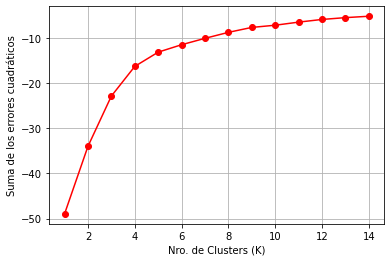

In [152]:
# Definimos rango de valores de K
rangeValueK = range(1, 15) 

# Iterar kmeans para el número de k establecido
vec_kmeans = []
for i in rangeValueK:
    vec_kmeans.append(KMeans(n_clusters=i))

# Ajustar cada modelo
score = []
for j in range(len(vec_kmeans)):
    score.append(vec_kmeans[j].fit(dfPCA).score(dfPCA))

# Grafica
plt.plot(rangeValueK, score, 'ro-')
plt.grid(True)
plt.xlabel('Nro. de Clusters (K)')
plt.ylabel('Suma de los errores cuadráticos')
plt.show()

En la gŕafica se puede observar que cuando <i>k=3</i> se forma el primer codo y la curva empieza a estabilizarse. Esto quiere decir que a partir del valor de <i>k</i> indicado, la distancia media dentro del cluster no ha mejorado (cálculo del nuevo centroide no cambia) por lo tanto se tiene de un cluster compacto.

In [153]:
k=3

In [154]:
modelKmeans = KMeans(n_clusters=k).fit(dfPCA)
centroides = modelKmeans.cluster_centers_
print(centroides)

[[-0.16845765 -0.09600192  0.06061802]
 [ 0.25419855  0.02583509 -0.04437284]
 [-0.41199451  0.70256677 -0.2226464 ]]


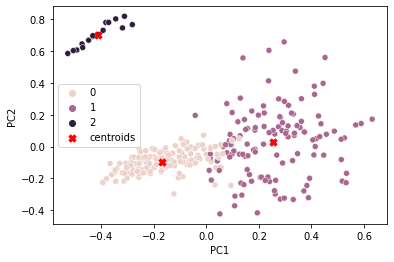

In [155]:
# Gráfica de dataset agrupamiento por modelo kmeans
y_kmeans = modelKmeans.predict(dfPCA)

sns.scatterplot(data=dfPCA, x="PC1", y="PC2", hue=modelKmeans.labels_, cmap='viridis')
plt.scatter(centroides[:,0], centroides[:,1], 
            marker="X", c="red", s=50, label="centroids")
plt.legend()
plt.show()

# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(dfPCA['PC1'],dfPCA['PC2'],dfPCA['PC3'], 
#             c=y_kmeans, cmap='viridis',
#             edgecolor='k', s=40, alpha = 0.5)


# ax.set_title("Cluster PCA Gentrificación")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
# ax.dist = 10

# ax.scatter(centroides[:,0], centroides[:,1], centroides[:,2], 
#            s = 300, c = 'r', marker='*', label = 'Centroid')

# plt.autoscale(enable=True, axis='x', tight=True)    

# plt.show()

In [156]:
# funcion calculo DUM (https://ruivieira.dev/dunn-index.html#26pyJOZRYA:0.VlJO32oJ3:2~sssee~2~4)
import numpy as np

def δ(ck, cl):
    values = np.ones([len(ck), len(cl)])
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
    return np.min(values)

def Δ(ci):
    values = np.zeros([len(ci), len(ci)])
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
    return np.max(values)

def dunn(k_list):
    δs = np.ones([len(k_list), len(k_list)])
    Δs = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            δs[k, l] = δ(k_list[k], k_list[l])
            Δs[k] = Δ(k_list[k])
            di = np.min(δs)/np.max(Δs)
    return di

# Almancenar Kmeans resultados en un dataframe
pred = pd.DataFrame(y_kmeans)
pred.columns = ['Type']

# Hacemos merge con dataframe principal
prediction = pd.concat([dfPCA, pred], axis = 1)

# Almacenamos los clustres en dataframe Prediccion
clus0 = prediction.loc[prediction.Type == 0]
clus1 = prediction.loc[prediction.Type == 1]
clus2 = prediction.loc[prediction.Type == 2]
cluster_list = [clus0.values, clus1.values, clus2.values]

dunn(cluster_list)

0.7466276854531082

> Para realizar el analisis de los clusters generados, se va a extraer la media de cada variable para cada clase (0,1,2)

In [157]:
df_integrado['Clase'] = pd.Series(y_kmeans, index=df_integrado.index)
df_integrado

,COD_DISBAR,BARRIOS,ANIO,LATITUD,LONGITUD,num_hospedajes,num_terrazas,num_personas_entre_15_a_44_anios,num_personas_desempleadas,num_personas_con_educacion_superior,num_personas_extranjeras,media_personas_por_vivienda,precio_vivienda_usadas_euro_m2,valor_renta_media,Clase
0,11,PALACIO,2016,4474110.875,439417.7914,19,146.0,9752.0,1362.0,9469.0,3652.0,2.01,3257.02,31912.67,1
1,11,PALACIO,2018,4474110.875,439417.7914,102,158.0,9664.0,1274.0,9892.0,3854.0,2.01,4105.46,34675.85,1
2,11,PALACIO,2019,4474110.875,439417.7914,1088,159.0,9894.0,1235.0,10409.0,4028.0,2.03,5044.74,35509.21,1
3,12,EMBAJADORES,2016,4473417.211,440397.1764,42,100.0,22623.0,3349.0,15438.0,11091.0,2.07,3040.69,23917.97,1
4,12,EMBAJADORES,2018,4473417.211,440397.1764,153,103.0,22410.0,2907.0,16482.0,11275.0,2.04,4187.39,25999.83,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,213,CASCO HISTÓRICO DE BARAJAS,2016,4480530.185,450931.3676,1,1.0,3076.0,539.0,1128.0,1188.0,2.41,1973.96,33312.14,0
289,213,CASCO HISTÓRICO DE BARAJAS,2019,4480530.185,450931.3676,19,23.0,3161.0,386.0,1360.0,1388.0,2.43,2954.66,37427.00,0
290,214,TIMÓN,2018,4480810.557,448842.3002,3,17.0,5046.0,472.0,3425.0,1091.0,2.67,3226.80,40271.04,0
291,214,TIMÓN,2019,4480810.557,448842.3002,35,18.0,5231.0,527.0,3696.0,1230.0,2.67,3370.35,41584.00,0


In [158]:
df_clase0 = df_integrado[df_integrado['Clase'] == 0] 
df_clase1 = df_integrado[df_integrado['Clase'] == 1] 
df_clase2 = df_integrado[df_integrado['Clase'] == 2] 

In [159]:
lstMediasC0 = [];
lstMediasC1 = [];
lstMediasC2 = [];
lstMediasC3 = [];
lstIndicador = ['num_hospedajes','num_terrazas', 'num_personas_con_educacion_superior', 
                'num_personas_desempleadas', 'media_personas_por_vivienda',
                'precio_vivienda_usadas_euro_m2', 'valor_renta_media']

# num_hospedajes
mean_clase0_hosepdaje = df_clase0['num_hospedajes'].mean()
mean_clase1_hosepdaje = df_clase1['num_hospedajes'].mean()
mean_clase2_hosepdaje = df_clase2['num_hospedajes'].mean()


# num_terrazas
mean_clase0_terrazas = df_clase0['num_terrazas'].mean()
mean_clase1_terrazas = df_clase1['num_terrazas'].mean()
mean_clase2_terrazas = df_clase2['num_terrazas'].mean()


# num_personas_con_educacion_superior
mean_clase0_educacion_superior = df_clase0['num_personas_con_educacion_superior'].mean()
mean_clase1_educacion_superior = df_clase1['num_personas_con_educacion_superior'].mean()
mean_clase2_educacion_superior = df_clase2['num_personas_con_educacion_superior'].mean()


# num_personas_extranjeras
mean_clase0_desempleadas = df_clase0['num_personas_desempleadas'].mean()
mean_clase1_desempleadas = df_clase1['num_personas_desempleadas'].mean()
mean_clase2_desempleadas = df_clase2['num_personas_desempleadas'].mean()


# media_personas_por_vivienda
mean_clase0_personas_por_vivienda = df_clase0['media_personas_por_vivienda'].mean()
mean_clase1_personas_por_vivienda = df_clase1['media_personas_por_vivienda'].mean()
mean_clase2_personas_por_vivienda = df_clase2['media_personas_por_vivienda'].mean()


# precio_vivienda_nueva_euro_m2
mean_clase0_precio_vivienda = df_clase0['precio_vivienda_usadas_euro_m2'].mean()
mean_clase1_precio_vivienda = df_clase1['precio_vivienda_usadas_euro_m2'].mean()
mean_clase2_precio_vivienda = df_clase2['precio_vivienda_usadas_euro_m2'].mean()


# valor_renta_media
mean_clase0_valor_renta_media = df_clase0['valor_renta_media'].mean()
mean_clase1_valor_renta_media = df_clase1['valor_renta_media'].mean()
mean_clase2_valor_renta_media = df_clase2['valor_renta_media'].mean()


# Construcción final del Dataframe resumen
lstMediasC0.append(mean_clase0_hosepdaje)
lstMediasC1.append(mean_clase1_hosepdaje)
lstMediasC2.append(mean_clase2_hosepdaje)

lstMediasC0.append(mean_clase0_terrazas)
lstMediasC1.append(mean_clase1_terrazas)
lstMediasC2.append(mean_clase2_terrazas)


lstMediasC0.append(mean_clase0_educacion_superior)
lstMediasC1.append(mean_clase1_educacion_superior)
lstMediasC2.append(mean_clase2_educacion_superior)

lstMediasC0.append(mean_clase0_desempleadas)
lstMediasC1.append(mean_clase1_desempleadas)
lstMediasC2.append(mean_clase2_desempleadas)

lstMediasC0.append(mean_clase0_personas_por_vivienda)
lstMediasC1.append(mean_clase1_personas_por_vivienda)
lstMediasC2.append(mean_clase2_personas_por_vivienda)

lstMediasC0.append(mean_clase0_precio_vivienda)
lstMediasC1.append(mean_clase1_precio_vivienda)
lstMediasC2.append(mean_clase2_precio_vivienda)

lstMediasC0.append(mean_clase0_valor_renta_media)
lstMediasC1.append(mean_clase1_valor_renta_media)
lstMediasC2.append(mean_clase2_valor_renta_media)

df_all_idnicadores = {'Valor_Medio_Clase_0': lstMediasC0,
                    'Valor_Medio_Clase_1': lstMediasC1, 
                    'Valor_Medio_Clase_2': lstMediasC2, 
                    'Indicador': lstIndicador}

dfSummary = pd.DataFrame(df_all_idnicadores, columns = ['Valor_Medio_Clase_0', 'Valor_Medio_Clase_1', 
                                               'Valor_Medio_Clase_2', 'Indicador'])
dfSummary

,Valor_Medio_Clase_0,Valor_Medio_Clase_1,Valor_Medio_Clase_2,Indicador
0,19.072848,93.746032,40.3125,num_hospedajes
1,26.860927,55.230159,43.2500,num_terrazas
2,5534.556291,10717.642857,0.0000,num_personas_con_educacion_superior
3,1766.768212,940.103175,0.0000,num_personas_desempleadas
4,2.573907,2.453651,0.0000,media_personas_por_vivienda
5,2235.541325,4488.221984,4018.8250,precio_vivienda_usadas_euro_m2
6,31486.870728,52470.137143,0.0000,valor_renta_media


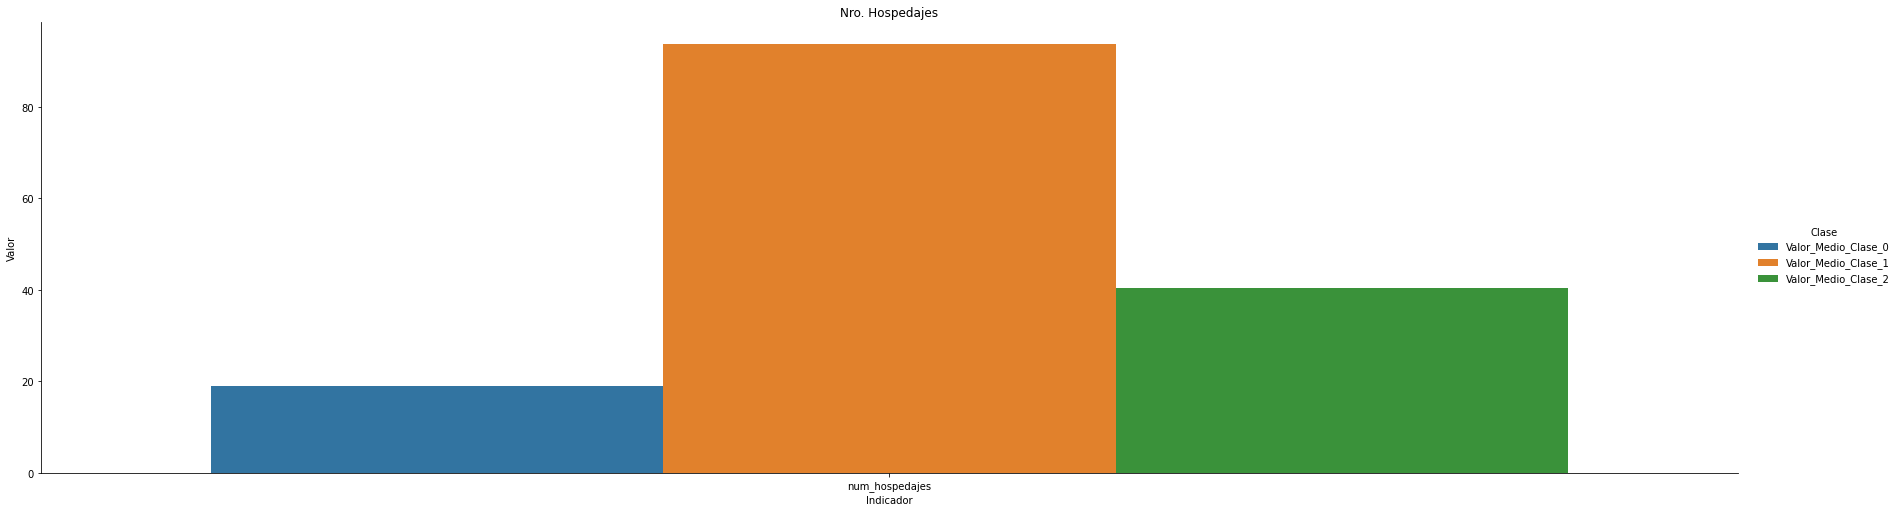

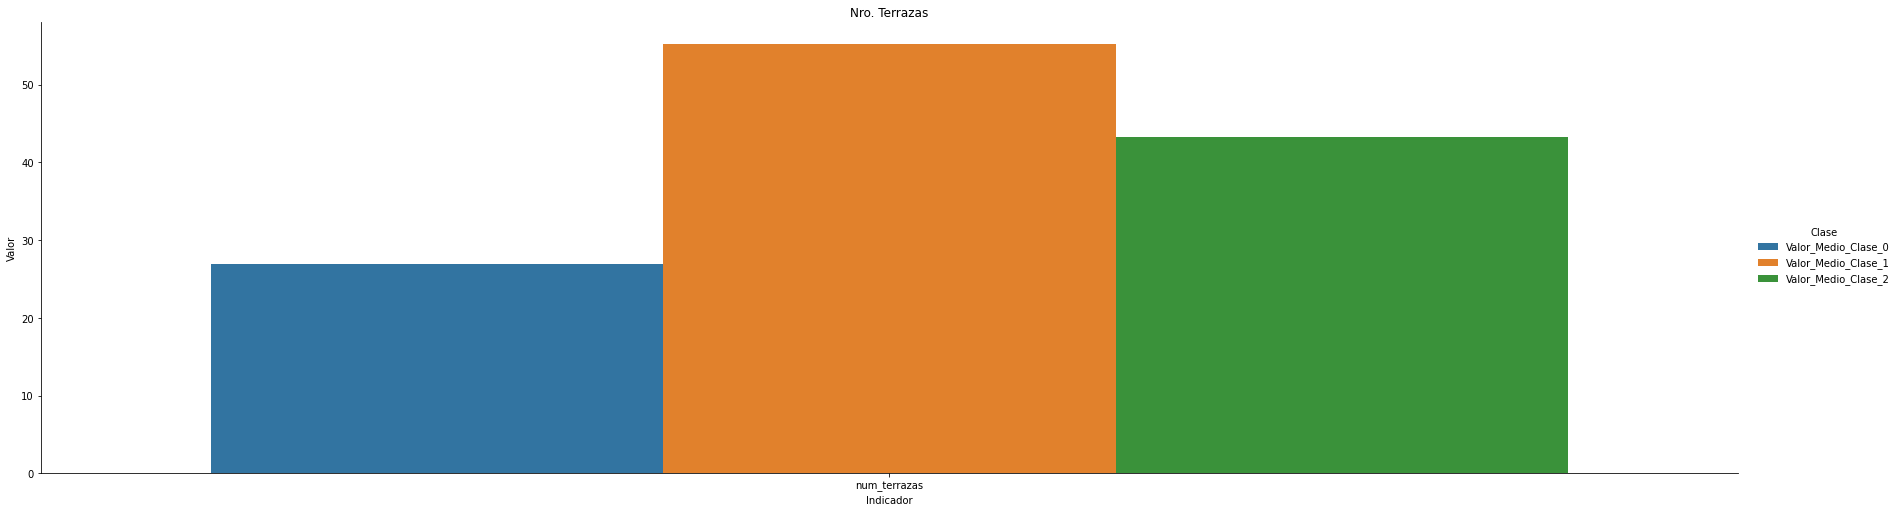

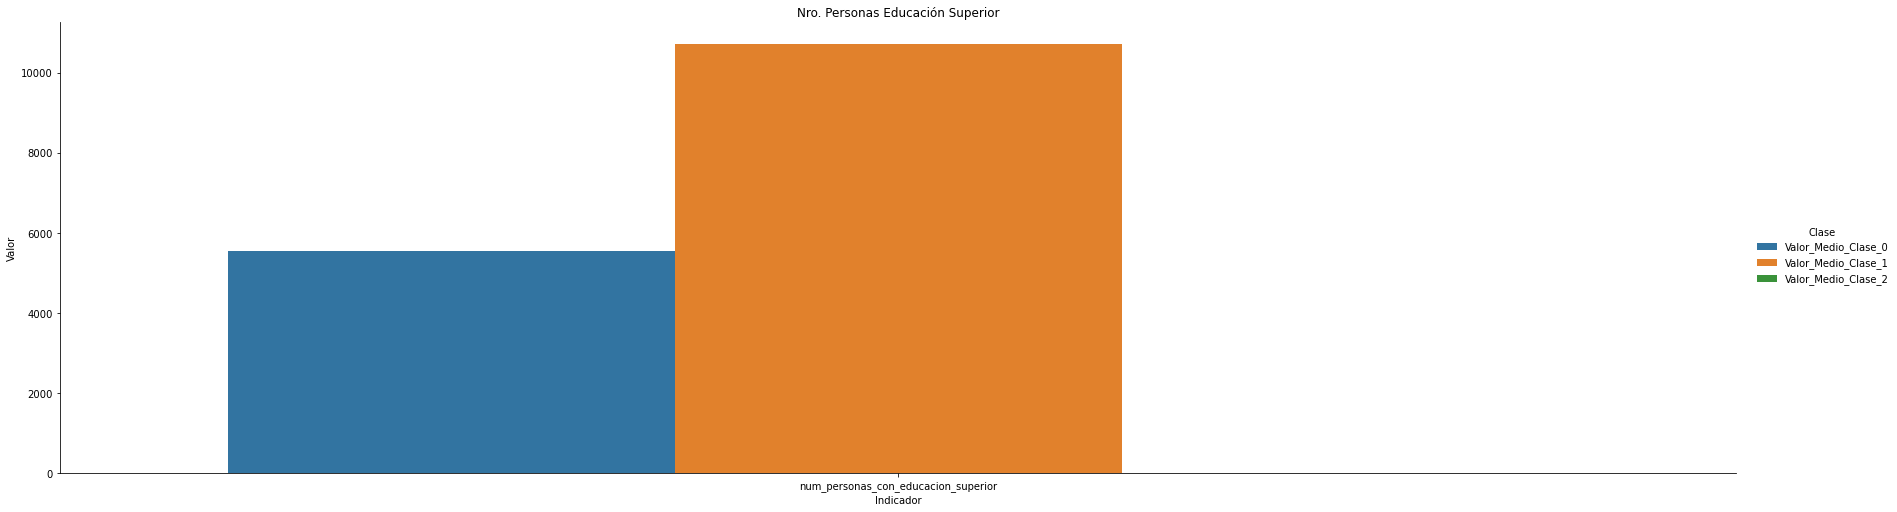

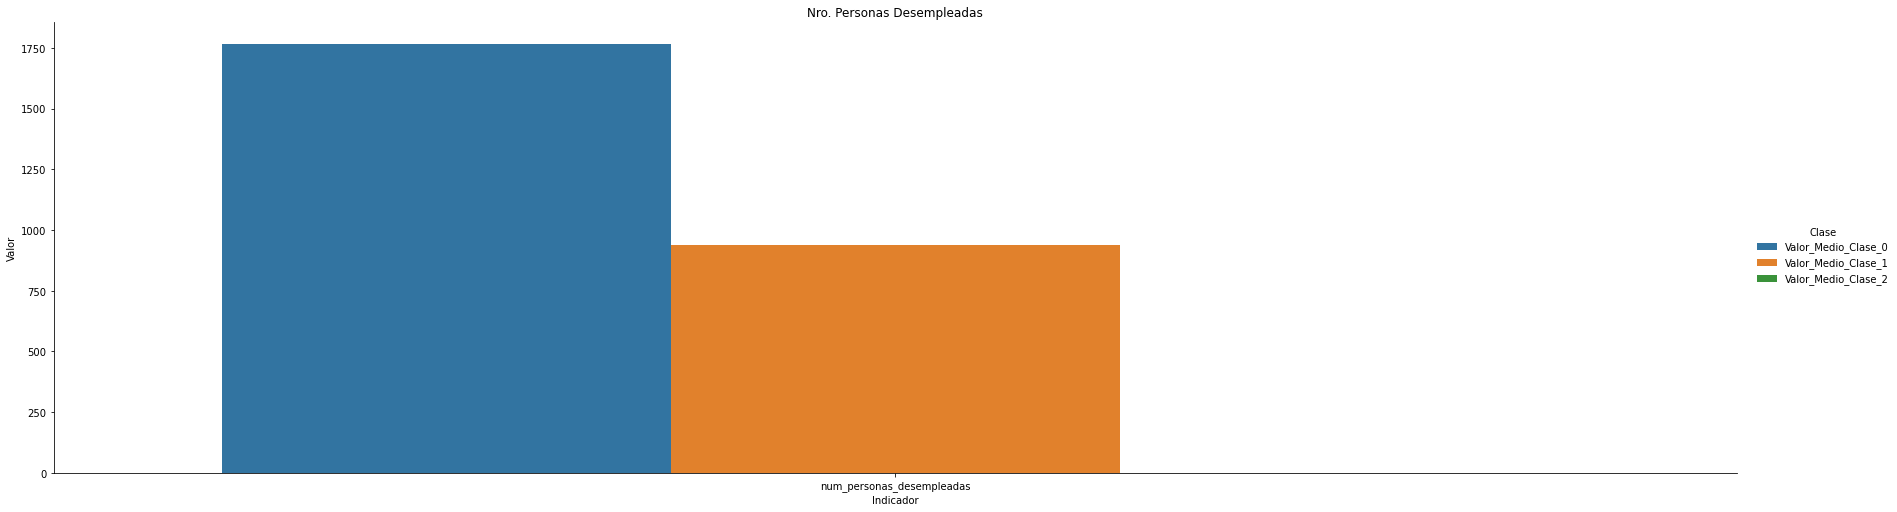

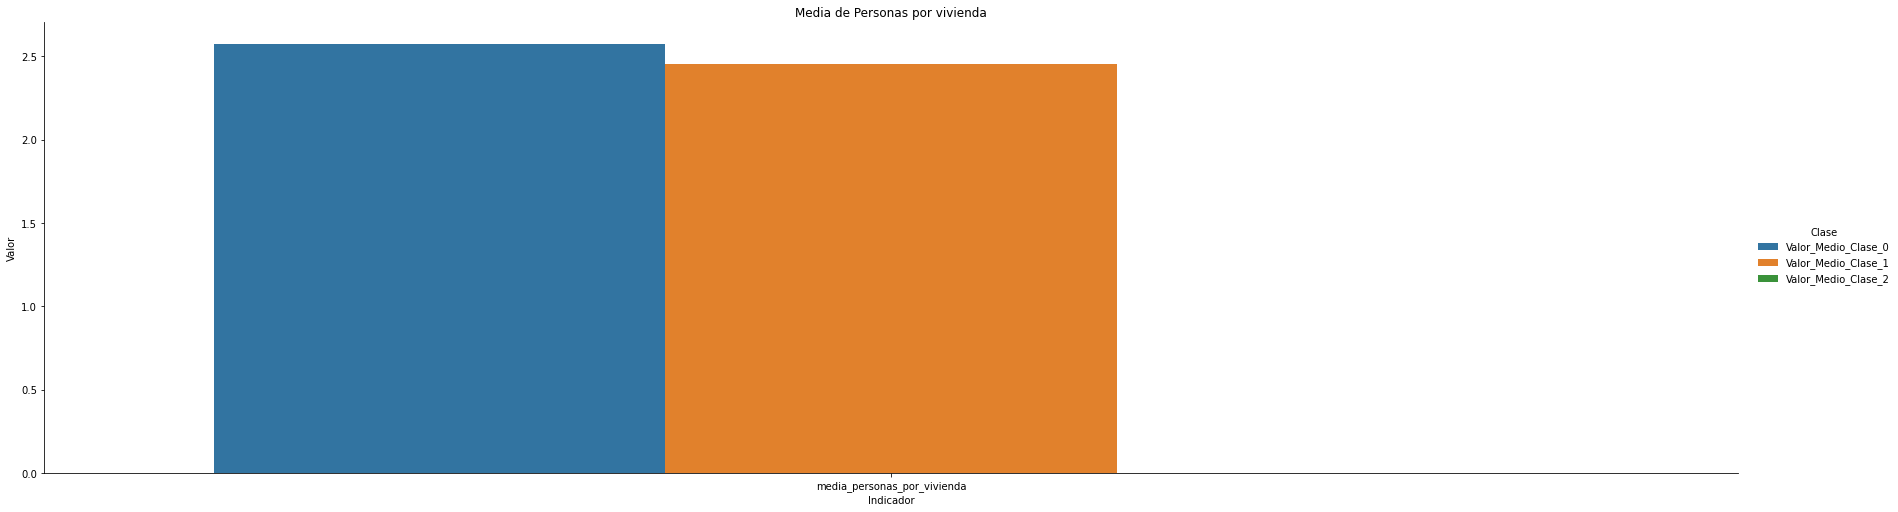

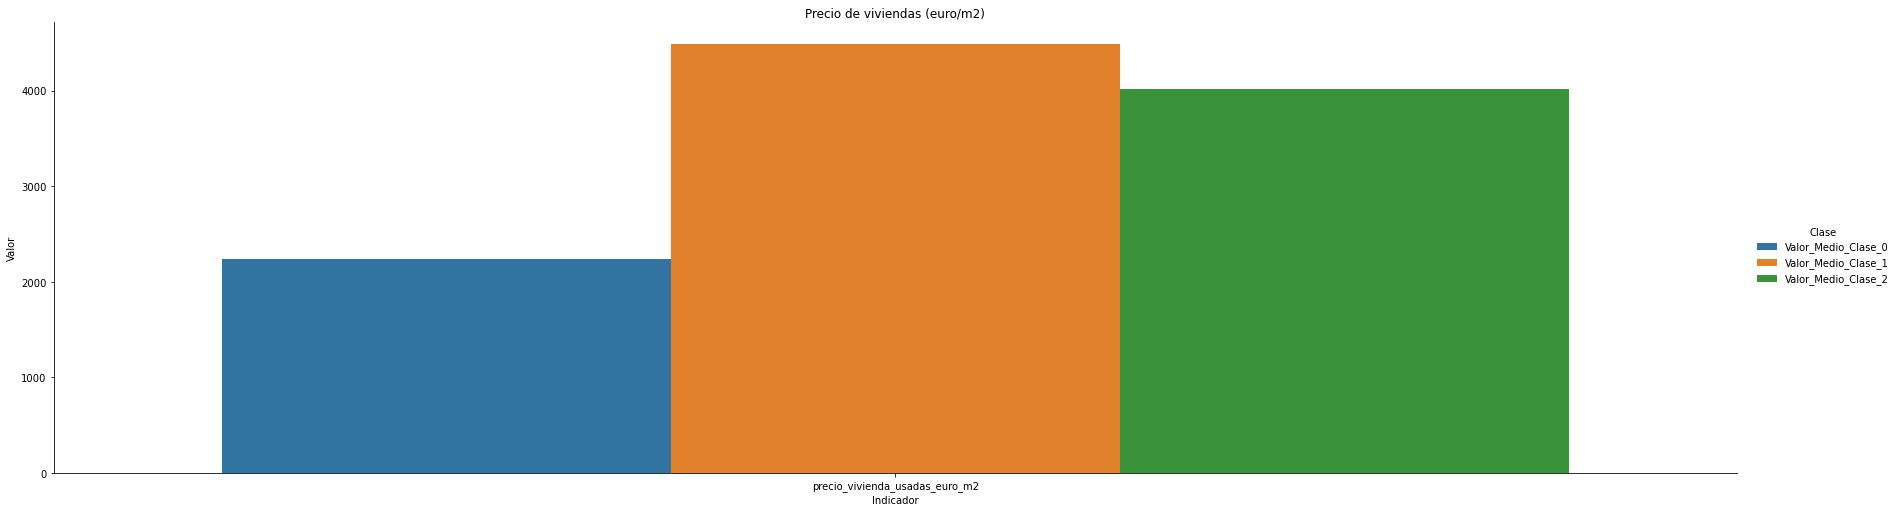

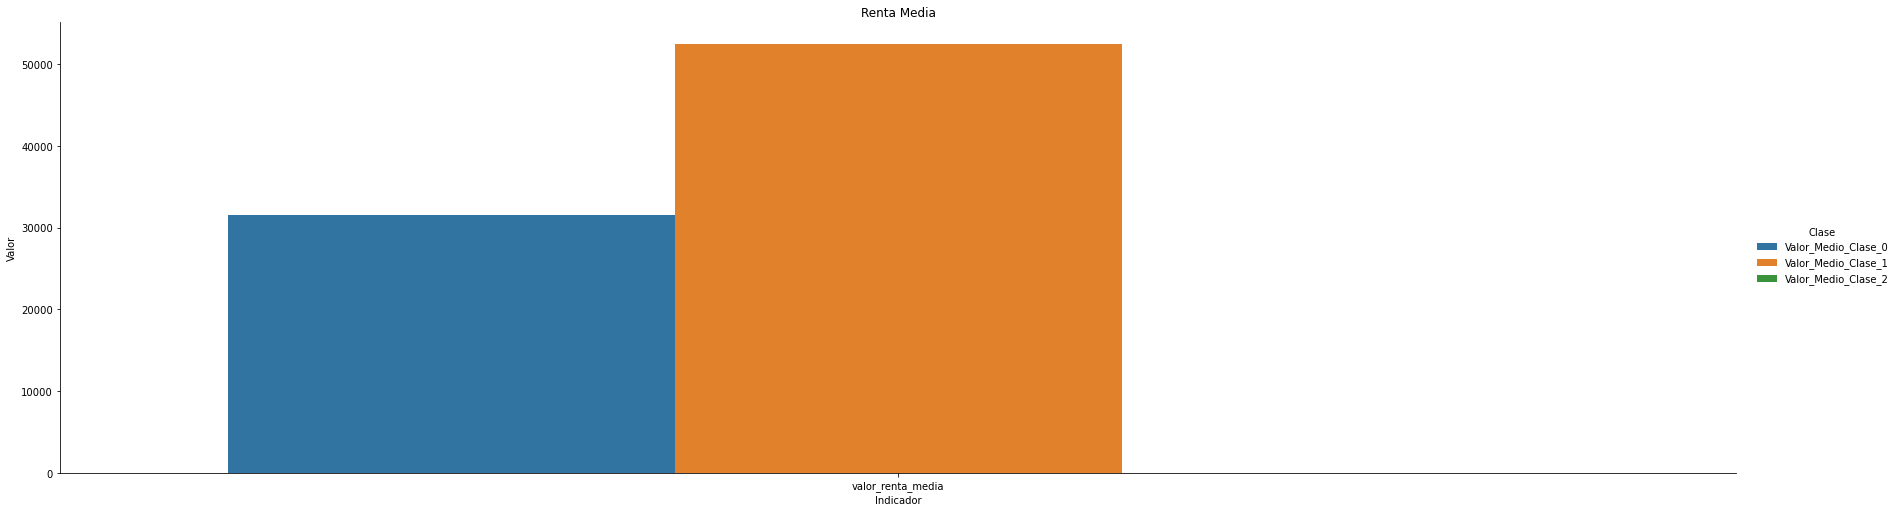

In [160]:
dfPlot = dfSummary.melt(id_vars=["Indicador"], 
        var_name="Clase", 
        value_name="Valor")

sns.catplot(x="Indicador", y="Valor", 
            hue="Clase", kind="bar", 
            data=dfPlot.loc[dfPlot['Indicador'] == 'num_hospedajes'], 
            height=7, aspect=3.5).set(title='Nro. Hospedajes')

sns.catplot(x="Indicador", y="Valor", 
            hue="Clase", kind="bar", 
            data=dfPlot.loc[dfPlot['Indicador'] == 'num_terrazas'], 
            height=7, aspect=3.5).set(title='Nro. Terrazas')

sns.catplot(x="Indicador", y="Valor", 
            hue="Clase", kind="bar", 
            data=dfPlot.loc[dfPlot['Indicador'] == 'num_personas_con_educacion_superior'], 
            height=7, aspect=3.5).set(title='Nro. Personas Educación Superior')

sns.catplot(x="Indicador", y="Valor", 
            hue="Clase", kind="bar", 
            data=dfPlot.loc[dfPlot['Indicador'] == 'num_personas_desempleadas'], 
            height=7, aspect=3.5).set(title='Nro. Personas Desempleadas')

sns.catplot(x="Indicador", y="Valor", 
            hue="Clase", kind="bar", 
            data=dfPlot.loc[dfPlot['Indicador'] == 'media_personas_por_vivienda'], 
            height=7, aspect=3.5).set(title='Media de Personas por vivienda')

sns.catplot(x="Indicador", y="Valor", 
            hue="Clase", kind="bar", 
            data=dfPlot.loc[dfPlot['Indicador'] == 'precio_vivienda_usadas_euro_m2'], 
            height=7, aspect=3.5).set(title='Precio de viviendas (euro/m2)')

sns.catplot(x="Indicador", y="Valor", 
            hue="Clase", kind="bar", 
            data=dfPlot.loc[dfPlot['Indicador'] == 'valor_renta_media'], 
            height=7, aspect=3.5).set(title='Renta Media')


En base a esta tabla de resumen, en base a los valores medios de cada clase y cada variable, se puede categorizar de que consiste cada clase, como se describe a continuación:

* Clase 0 (Riesgo bajo de gentrificación)
* Clase 1 (Gentrificando)
* Clase 2 (Riesgo medio de gentrificación)

In [161]:
df_integrado.loc[df_integrado['Clase'] == 0, 'Clase'] = 'Riesgo bajo de gentrificación'
df_integrado.loc[df_integrado['Clase'] == 1, 'Clase'] = 'Gentrificando'
df_integrado.loc[df_integrado['Clase'] == 2, 'Clase'] = 'Riesgo medio de gentrificación'

In [162]:
df_integrado.to_csv('../../dataset/barrios_clusterizados_result.csv', index=False)

In [163]:
df_integrado

,COD_DISBAR,BARRIOS,ANIO,LATITUD,LONGITUD,num_hospedajes,num_terrazas,num_personas_entre_15_a_44_anios,num_personas_desempleadas,num_personas_con_educacion_superior,num_personas_extranjeras,media_personas_por_vivienda,precio_vivienda_usadas_euro_m2,valor_renta_media,Clase
0,11,PALACIO,2016,4474110.875,439417.7914,19,146.0,9752.0,1362.0,9469.0,3652.0,2.01,3257.02,31912.67,Gentrificando
1,11,PALACIO,2018,4474110.875,439417.7914,102,158.0,9664.0,1274.0,9892.0,3854.0,2.01,4105.46,34675.85,Gentrificando
2,11,PALACIO,2019,4474110.875,439417.7914,1088,159.0,9894.0,1235.0,10409.0,4028.0,2.03,5044.74,35509.21,Gentrificando
3,12,EMBAJADORES,2016,4473417.211,440397.1764,42,100.0,22623.0,3349.0,15438.0,11091.0,2.07,3040.69,23917.97,Gentrificando
4,12,EMBAJADORES,2018,4473417.211,440397.1764,153,103.0,22410.0,2907.0,16482.0,11275.0,2.04,4187.39,25999.83,Gentrificando
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,213,CASCO HISTÓRICO DE BARAJAS,2016,4480530.185,450931.3676,1,1.0,3076.0,539.0,1128.0,1188.0,2.41,1973.96,33312.14,Riesgo bajo de gentrificación
289,213,CASCO HISTÓRICO DE BARAJAS,2019,4480530.185,450931.3676,19,23.0,3161.0,386.0,1360.0,1388.0,2.43,2954.66,37427.00,Riesgo bajo de gentrificación
290,214,TIMÓN,2018,4480810.557,448842.3002,3,17.0,5046.0,472.0,3425.0,1091.0,2.67,3226.80,40271.04,Riesgo bajo de gentrificación
291,214,TIMÓN,2019,4480810.557,448842.3002,35,18.0,5231.0,527.0,3696.0,1230.0,2.67,3370.35,41584.00,Riesgo bajo de gentrificación


## Comparación de categorías IG vs Modelo

In [206]:
# Lectura de CVS clasificado por IG.
df_ind_gentrificacion = pd.read_csv('../../dataset/barrios_indice_gentrificacion_result.csv')
df_ind_gentrificacion = df_ind_gentrificacion.iloc[:, [0,1,2,15]]
df_ind_gentrificacion.rename(columns = {'ESTADOGENTRIFICACION':'Clase'}, inplace = True)
df_ind_gentrificacion.head()

,COD_DISBAR,BARRIOS,ANIO,Clase
0,11,PALACIO,2016,Gentrificando
1,11,PALACIO,2018,Gentrificando
2,11,PALACIO,2019,Gentrificando
3,12,EMBAJADORES,2016,Gentrificando
4,12,EMBAJADORES,2018,Gentrificando


In [207]:
# Lectura de CVS clasificado por modelo.
df_etiquetado_modelo = pd.read_csv('../../dataset/barrios_clusterizados_result.csv')
df_etiquetado_modelo = df_etiquetado_modelo.iloc[:, [0,1,2,14]]
df_etiquetado_modelo.head()

,COD_DISBAR,BARRIOS,ANIO,Clase
0,11,PALACIO,2016,Gentrificando
1,11,PALACIO,2018,Gentrificando
2,11,PALACIO,2019,Gentrificando
3,12,EMBAJADORES,2016,Gentrificando
4,12,EMBAJADORES,2018,Gentrificando


### Comparación

In [210]:
result_diff =  df_etiquetado_modelo == df_ind_gentrificacion

result_diff

,COD_DISBAR,BARRIOS,ANIO,Clase
0,True,True,True,True
1,True,True,True,True
2,True,True,True,True
3,True,True,True,True
4,True,True,True,True
...,...,...,...,...
288,True,True,True,True
289,True,True,True,True
290,True,True,True,True
291,True,True,True,True


In [216]:
clases_modelo = df_etiquetado_modelo["Clase"]
result_diff.insert(1, "Clase_Mod", clases_modelo)
result_diff

,COD_DISBAR,Clase_Mod,ClaseMod,BARRIOS,ANIO,Clase
0,True,Gentrificando,Gentrificando,True,True,True
1,True,Gentrificando,Gentrificando,True,True,True
2,True,Gentrificando,Gentrificando,True,True,True
3,True,Gentrificando,Gentrificando,True,True,True
4,True,Gentrificando,Gentrificando,True,True,True
...,...,...,...,...,...,...
288,True,Riesgo bajo de gentrificación,Riesgo bajo de gentrificación,True,True,True
289,True,Riesgo bajo de gentrificación,Riesgo bajo de gentrificación,True,True,True
290,True,Riesgo bajo de gentrificación,Riesgo bajo de gentrificación,True,True,True
291,True,Riesgo bajo de gentrificación,Riesgo bajo de gentrificación,True,True,True


### Fallos y aciertos: Estado Gentrificando


In [252]:
result_diff_G = result_diff[result_diff['Clase_Mod'] == 'Gentrificando'] 
table_G = result_diff_G['Clase'].value_counts()
table_G

True     67
False    59
Name: Clase, dtype: int64

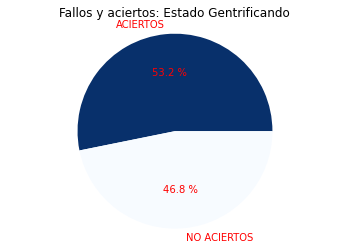

In [253]:
from matplotlib import cm
from matplotlib import colors

nombres = ["ACIERTOS","NO ACIERTOS"]

normdata = colors.Normalize(min(table_G), max(table_G))
colormap = cm.get_cmap("Blues")
colores =colormap(normdata(table_G))

plt.pie(table_G, labels=nombres, autopct="%0.1f %%", colors=colores, textprops={'color':"r"})
plt.axis("equal")
plt.title("Fallos y aciertos: Estado Gentrificando")
plt.show()

### Fallos y aciertos: Estado Riesgo Medio

In [254]:
result_diff_RMG = result_diff[result_diff['Clase_Mod'] == 'Riesgo medio de gentrificación'] 
table_RMG = result_diff_RMG['Clase'].value_counts()
table_RMG

False    16
Name: Clase, dtype: int64

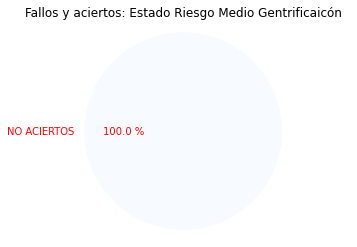

In [255]:
from matplotlib import cm
from matplotlib import colors

nombres = ["NO ACIERTOS"]

normdata = colors.Normalize(min(table_RMG), max(table_RMG))
colormap = cm.get_cmap("Blues")
colores =colormap(normdata(table_RMG))

plt.pie(table_RMG, labels=nombres, autopct="%0.1f %%", colors=colores, textprops={'color':"r"})
plt.axis("equal")
plt.title("Fallos y aciertos: Estado Riesgo Medio Gentrificaicón")
plt.show()

### Fallos y aciertos: Estado Riesgo Bajo

In [256]:
result_diff_RBG = result_diff[result_diff['Clase_Mod'] == 'Riesgo bajo de gentrificación'] 
table_RBG = result_diff_RBG['Clase'].value_counts()
table_RBG

False    76
True     75
Name: Clase, dtype: int64

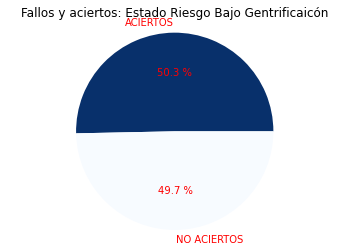

In [257]:
from matplotlib import cm
from matplotlib import colors

nombres = ["ACIERTOS","NO ACIERTOS"]

normdata = colors.Normalize(min(table_RBG), max(table_RBG))
colormap = cm.get_cmap("Blues")
colores =colormap(normdata(table_RBG))

plt.pie(table_RBG, labels=nombres, autopct="%0.1f %%", colors=colores, textprops={'color':"r"})
plt.axis("equal")
plt.title("Fallos y aciertos: Estado Riesgo Bajo Gentrificaicón")
plt.show()